# Lab. 7: Bio-Inspired Optimization

## Introduction

#### <u>The goal of this lab is to study different Bio-Inspired Optimization techniques.</u>

**Disclamer**
- When studying the effect of the parameters is extremely important to vary just one parameter at a time. Therefore, you are suggested to study one parameter by fixing all the others, and then moving to the next.

- When comparing different algorithms, is very important to run each of them several times (e.g., 30) by using different initial random seeds.

In [ ]:
import functools
from copy import deepcopy
from dataclasses import dataclass
from functools import reduce
from random import Random
from typing import Any, Optional

import benchmark_functions as bf
import inspyred
import numpy as np
import pylab as pl
from inspyred.ec import (
    EvolutionaryComputation,
    Individual,
    replacers,
    selectors,
    terminators,
    variators,
)
from inspyred.swarm import topologies
from matplotlib import pyplot as plt
from numpy.typing import NDArray

### Helper functions

In [ ]:
from typing import Callable

GLOBAL = "Global"
INDIVIDUAL = "Individual"
CORRELATED = "Correlated"

STAR = "star"
RING = "ring"


class OptFun:
    def __init__(self, wf: bf.BenchmarkFunction):
        self.f = wf
        self.history: list[list[float]] = []
        self.__name__ = f"OptFun({wf.__class__})"

    def __call__(
        self, candidates: list[list[float]], *args: Any, **kwargs: Any
    ) -> list[float]:
        """
        Evaluate the objective function for a list of candidates.
        """
        y: list[float] = []
        for x0 in candidates:
            self.history.append(deepcopy(x0))
            y.append(self.f(x0))  # type: ignore
        return y

    def minima(self) -> list[bf.fil.Optimum]:
        return self.f.minima()

    def bounder(self) -> Callable[[list[float], tuple[float, ...]], list[float]]:
        def fcn(candidate: list[float], *args: tuple[float, ...]) -> list[float]:
            bounds: tuple[list[float], list[float]] = self.f.suggested_bounds()

            for i, (m, M) in enumerate(zip(*bounds)):
                if candidate[i] < m:
                    candidate[i] = m
                if candidate[i] > M:
                    candidate[i] = M
            return candidate

        return fcn

    def bounds(self) -> list[tuple[float, float]]:
        """
        Return the bounds of the objective function.
        """
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, filename: Optional[str] = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title("Benchmark Function: " + self.f.name())  # type: ignore
        fig.suptitle(self.f.name())
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f.n_dimensions() > 1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray(
                [
                    [self.f((X[i][j], Y[i][j])) for j in range(len(X[i]))]
                    for i in range(len(X))
                ]
            )
        else:
            raise ValueError("Function has only one dimension.")

        plt.contour(x, y, Z, 15, linewidths=0.5, colors="k")  # hight lines
        plt.contourf(
            x, y, Z, 15, cmap="viridis", vmin=Z.min(), vmax=Z.max()
        )  # heat map
        plt.xlabel("x")
        plt.ylabel("y")
        cbar = plt.colorbar()
        cbar.set_label("z")
        if len(self.history) > 0:  # plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=3, linewidth=1)
        if filename is None:
            plt.show()
        else:
            plt.savefig(filename, dpi=400)

    def plot(self):
        """
        Plot the history of the objective function values.
        """
        plt.clf()
        values = [self.f(v) for v in self.history]
        min_value: float = self.minima()[0].score  # type: ignore
        plt.plot(values)
        plt.axhline(min_value, color="r", label="optimum")
        plt.legend(loc="upper right")
        plt.show()

    def _convert_bounds(
        self, bounds: tuple[list[float], list[float]]
    ) -> list[tuple[float, float]]:
        """
        Convert bounds to a list of tuples.
        """
        return [(bounds[0][i], bounds[1][i]) for i in range(len(bounds[0]))]

    def current_calls(self) -> int:
        """
        Return the number of calls to the objective function.
        """
        return len(self.history)

In [122]:
from typing import Callable


class NumpyRandomWrapper(pl.RandomState):
    def __init__(self, seed: Optional[int] = None):
        super(NumpyRandomWrapper, self).__init__(seed)

    def sample(self, population: list[int] | int, k: int):
        if isinstance(population, int):
            population = list(range(population))

        return pl.asarray(
            [
                population[i]
                for i in self._choice_without_replacement(len(population), k)
            ]
        )

    def random(self) -> float:  # type: ignore
        return self.random_sample()

    def gauss(self, mu: float, sigma: float) -> float:
        return self.normal(mu, sigma)

    def _choice_without_replacement(self, n: int, size: int) -> set[int]:
        result = set()
        while len(result) < size:
            result.add(self.randint(0, n))
        return result


def initial_pop_observer(
    population: list[Individual],
    num_generations: int,
    num_evaluations: int,
    args: dict[str, Any],
) -> None:
    print(population)
    if num_generations == 0:
        args["initial_pop_storage"]["individuals"] = pl.asarray(
            [guy.candidate for guy in population]
        )
        args["initial_pop_storage"]["fitnesses"] = pl.asarray(
            [guy.fitness for guy in population]
        )


def generator(random: Random, args: dict[str, Any]) -> NDArray[pl.float64]:
    return pl.asarray(
        [
            random.uniform(args["pop_init_range"][0], args["pop_init_range"][1])
            for _ in range(args["num_vars"])
        ]
    )


def generator_wrapper(
    func: Callable[[Random, dict[str, Any]], NDArray[pl.float64]]
) -> Callable[[Random, dict[str, Any]], NDArray[pl.float64]]:
    @functools.wraps(func)
    def _generator(random: Random, args: dict[str, Any]):
        return pl.asarray(func(random, args))

    return _generator


# helper function used to store the various populations at each generation
def my_archiver(
    random: Random,
    population: list[Individual],
    archive: list[list[Individual]],
    args: dict[str, Any],
) -> list[list[Individual]]:
    archive.append(population)
    return archive


def run_ga(
    random: Random,
    func: OptFun,
    num_vars: int = 0,
    maximize: bool = False,
    **kwargs: Any,
) -> tuple[
    NDArray[pl.float64], float, list[Individual], list[list[NDArray[pl.float64]]]
]:

    # create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = EvolutionaryComputation(random)
    algorithm.terminator = terminators.generation_termination
    algorithm.replacer = replacers.generational_replacement
    algorithm.variator = [  # type: ignore
        variators.uniform_crossover,
        variators.gaussian_mutation,
    ]
    algorithm.selector = selectors.tournament_selection
    algorithm.archiver = my_archiver
    algorithm.observer = initial_pop_observer

    kwargs["num_selected"] = kwargs["pop_size"]

    kwargs["bounder"] = func.bounder()
    kwargs["generator"] = generator

    final_pop: list[Individual] = algorithm.evolve(
        evaluator=func,
        maximize=False,
        initial_pop_storage=initial_pop_storage,
        num_vars=num_vars,
        **kwargs,
    )

    all_populations: list[list[Individual]] = algorithm.archive  # type: ignore
    all_candidates: list[list[NDArray[pl.float64]]] = [[] for _ in all_populations]
    for i in range(len(all_populations)):
        all_candidates[i] = [elem.candidate for elem in all_populations[i]]  # type: ignore

    # best_guy = final_pop[0].candidate
    # best_fitness = final_pop[0].fitness
    final_pop_fitnesses: NDArray[pl.float64] = pl.asarray(
        [guy.fitness for guy in final_pop]
    )
    final_pop_candidates: NDArray[pl.float64] = pl.asarray(
        [guy.candidate for guy in final_pop]
    )

    sort_indexes = sorted(
        range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__
    )
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy: NDArray[pl.float64] = final_pop_candidates[0]
    best_fitness: float = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_candidates


class ES(EvolutionaryComputation):
    """Evolution Strategy EC

    This class is a stub for you to implement progressively more
    sophisticated evolution strategies.

    Optional keyword arguments in ``evolve`` args parameter that you
    will need add support for:

    - *strategy_mode* -- One of {None, 'global', 'individual', 'correlated'}
    - *epsilon* -- the minimum allowed strategy parameter (default 0.00001)
    - *tau* -- a global proportionality constant (default None)
    - *tau_i* -- an individual proportionality constant (default None)
    - *num_offspring* -- number of offspring to generate at each iteration
                        (``\\lambda``) should be a multiple of \\mu
    - *mixing_number* -- mixing number (``\\rho``) (number of parents
                        involved in producing each offspring),
                        default 1 (no-mixing)

    If *tau* is ``None``, it will be set to ``1 / sqrt(2*n)``, where
    ``n`` is the length of a candidate. If *tau_i* is ``None``, it will be
    set to ``1 / sqrt(2*sqrt(n))``.

    """

    def __init__(self, random: Random):
        EvolutionaryComputation.__init__(self, random)
        self.selector = selectors.default_selection
        self.variator = self._internal_variation
        # self.replacer = replacers.comma_replacement
        self.replacer = replacers.plus_replacement

    def elementary_rotation(
        self, p: int, q: int, alphas: list[float]
    ) -> NDArray[pl.float64]:
        num_vars: int = self.num_vars  # type: ignore
        R = pl.ones((num_vars, num_vars))

        # taken from Schwefel et al "Contemporary Evolution Strategies"
        k = int(0.5 * (2 * num_vars - p - 1) * (p + 2) - 2 * num_vars + q)
        cos_alpha = pl.cos(alphas[k])
        sin_alpha = pl.sin(alphas[k])
        R[p][p] = cos_alpha
        R[q][q] = cos_alpha
        R[p][q] = -sin_alpha
        R[q][p] = sin_alpha
        return R

    def _internal_variation(
        self,
        random: Random | NumpyRandomWrapper,
        candidates: list[list[float]],
        args: dict[str, Any],
    ):
        tau = args.setdefault("tau", None)
        tau_i = args.setdefault("tau", None)
        epsilon = args.setdefault("epsilon", 0.00001)

        # num_offspring (\\lambda)
        num_offspring = args.setdefault("num_offspring", len(candidates))

        mixing_number = args.setdefault("mixing_number", 1)

        if num_offspring % len(candidates) != 0:
            raise Exception(
                "num_offspring (\\lambda) should be a multiple " + "of pop_size (\\mu)"
            )

        mutants: list[NDArray[pl.float64]] = []
        num_vars: int = self.num_vars  # type: ignore

        if tau is None:
            tau = 1.0 / pl.sqrt(2 * num_vars)
        if tau_i is None:
            tau_i = 1.0 / pl.sqrt(2 * pl.sqrt(num_vars))

        while len(mutants) < num_offspring:
            parent_family_indices = random.sample(
                [*range(len(candidates))], mixing_number
            )
            parent_family = pl.asarray([candidates[i] for i in parent_family_indices])
            parent = parent_family.mean(0)

            cand = parent[: self.num_vars].copy()
            if self.strategy_mode is None:
                strat = []
                sigma = args.setdefault("sigma", 1.0)
                if isinstance(random, NumpyRandomWrapper):
                    cand += random.normal(0, sigma, cand.shape)
                else:
                    for i, c in enumerate(cand):
                        cand[i] = c + random.gauss(0, sigma)

            else:
                strat = parent[self.num_vars :].copy()

                if self.strategy_mode is GLOBAL:
                    sigmas = strat
                else:
                    sigmas = strat[: self.num_vars]  # view into strat

                e_global = tau * random.gauss(0, 1)

                # more efficient with sumpy
                if isinstance(random, NumpyRandomWrapper):
                    sigmas *= pl.exp(
                        e_global + tau_i * random.normal(0, 1, sigmas.shape)
                    )
                    sigmas = pl.maximum(sigmas, epsilon)
                else:
                    for i, s in enumerate(sigmas):
                        sigmas[i] = s * pl.exp(e_global + tau_i * random.gauss(0, 1))
                        sigmas[i] = max(strat[i], epsilon)

                if self.strategy_mode is CORRELATED:
                    alphas = strat[self.num_vars :]  # another view into strat
                    beta_squared = (5.0 * pl.pi / 180) ** 2  # 5 deg squared
                    if isinstance(random, NumpyRandomWrapper):
                        alphas += random.normal(0, beta_squared, alphas.shape) + pl.pi
                        alphas %= 2 * pl.pi
                        alphas -= pl.pi
                    else:
                        for j, a in enumerate(alphas):
                            alphas[j] = (
                                (a + random.gauss(0, beta_squared) + pl.pi)
                                % (2 * pl.pi)
                            ) - pl.pi

                if self.strategy_mode is GLOBAL:
                    sigma = sigmas[0]
                    if isinstance(random, NumpyRandomWrapper):
                        cand = cand + random.normal(0, sigma, cand.shape)
                    else:
                        for i, c in enumerate(cand):
                            cand[i] = c + random.gauss(0, sigma)
                elif self.strategy_mode is INDIVIDUAL:
                    if isinstance(random, NumpyRandomWrapper):
                        cand += random.multivariate_normal(
                            pl.zeros(num_vars), pl.diag(sigmas**2)
                        )
                    else:
                        for i, (c, s) in enumerate(zip(cand, sigmas)):
                            cand[i] = c + random.gauss(0, s)
                elif self.strategy_mode is CORRELATED:
                    # build correlation matrix
                    T = reduce(
                        pl.dot,
                        [
                            reduce(
                                pl.dot,
                                [
                                    self.elementary_rotation(p, q, alphas)  # type: ignore
                                    for q in range(p + 1, num_vars)
                                ],
                            )
                            for p in range(num_vars - 1)
                        ],
                    )
                    if isinstance(random, NumpyRandomWrapper):
                        cand += random.multivariate_normal(
                            pl.zeros(num_vars), pl.dot(T, pl.diag(sigmas**2))
                        )
                    else:
                        raise Exception(
                            "NumpyRandomWrapper required" + " for correlated mutations"
                        )
                else:
                    raise Exception("Unknown strategy mode")

            cand = self.bounder(cand, args)
            cand: NDArray[pl.float64] = np.concatenate((cand, strat))
            mutants.append(cand)

        return mutants

    def _internal_evaluator(
        self, func: OptFun
    ) -> Callable[[list[list[NDArray[pl.float64]]], dict[str, Any]], list[float]]:
        @functools.wraps(func)
        def evaluator(
            candidates: list[list[NDArray[pl.float64]]], args: dict[str, Any]
        ):
            # convert candidates to array and then back to list
            # makes slicing easier
            return func(list(pl.asarray(candidates)[:, 0 : self.num_vars]), args)

        return evaluator

    def strategize(
        self, generator: Callable[[Random, dict[str, Any]], NDArray[pl.float64]]
    ):
        """Add strategy parameters to candidates created by a generator.

        This function decorator is used to provide a means of adding strategy
        parameters to candidates created by a generator. The generator function
        is modifed to extend the candidate with strategy parameters based on
        the strategy_mode argument passed to evolve.

        Each strategy parameter is initialized to a random value:
        in [0, 1] for ``\\sigma_i`` and in [-pi,pi] for ``\\alpha_i``

        """

        @functools.wraps(generator)
        def strategy_generator(random: Random, args: Any) -> NDArray[pl.float64]:
            candidate = generator(random, args)
            num_vars: int = self.num_vars  # type: ignore
            if self.strategy_mode is None:
                return candidate
            elif self.strategy_mode is GLOBAL:
                return np.concatenate((candidate, [random.random()]))
            else:
                sigmas = [random.random() for _ in range(num_vars)]
                if self.strategy_mode is INDIVIDUAL:
                    return np.concatenate((candidate, sigmas))
                elif self.strategy_mode is CORRELATED:
                    # since have python random, do it like this... would be
                    # better with numpy
                    alphas = [
                        random.uniform(-pl.pi, pl.pi)
                        for _ in range((num_vars**2 - num_vars) // 2)
                    ]
                    return np.concatenate((candidate, alphas, sigmas))
                else:
                    raise Exception("Unknown strategy mode")

        return strategy_generator

    def evolve(
        self,
        generator: Callable[[Random, dict[str, Any]], NDArray[pl.float64]],
        evaluator: OptFun,
        pop_size: int = 100,
        seeds: Optional[list[int]] = None,
        maximize: bool = False,
        bounder: Optional[
            Callable[[list[float], tuple[float, ...]], list[float]]
        ] = None,
        strategy_mode: Optional[str] = None,
        num_vars: Optional[int] = None,
        **args: dict[str, Any],
    ) -> list[Individual]:
        self.strategy_mode = strategy_mode
        self.num_vars = num_vars

        generator = self.strategize(generator)
        evaluator = self._internal_evaluator(evaluator)  # type: ignore
        return EvolutionaryComputation.evolve(
            self,
            generator,
            evaluator,
            pop_size,
            seeds,
            maximize=maximize,
            num_vars=num_vars,
            bounder=bounder,
            **args,
        )


def run_es(
    random: Random,
    func: OptFun,
    num_vars: int = 0,
    maximize: bool = False,
    **kwargs: Any,
) -> tuple[
    NDArray[pl.float64], float, list[Individual], list[list[NDArray[pl.float64]]]
]:

    # create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = ES(random)
    algorithm.terminator = terminators.generation_termination

    algorithm.observer = initial_pop_observer
    algorithm.archiver = my_archiver

    kwargs["num_selected"] = kwargs["pop_size"]
    kwargs["bounder"] = func.bounder()
    kwargs["generator"] = generator_wrapper(generator)

    final_pop = algorithm.evolve(
        evaluator=func,
        maximize=maximize,
        initial_pop_storage=initial_pop_storage,
        num_vars=num_vars,
        **kwargs,
    )
    all_populations: list[list[Individual]] = algorithm.archive  # type: ignore
    all_candidates: list[list[NDArray[pl.float64]]] = [[] for _ in all_populations]
    for i in range(len(all_populations)):
        all_candidates[i] = [elem.candidate for elem in all_populations[i]]  # type: ignore

    # best_guy = final_pop[0].candidate[0:num_vars]
    # best_fitness = final_pop[0].fitness
    final_pop_fitnesses = pl.asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = pl.asarray([guy.candidate[0:num_vars] for guy in final_pop])  # type: ignore

    sort_indexes = sorted(
        range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__
    )
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_candidates


# This class inherit from the original inspyred.swarm.PSO class to allow archive
# of all the populations at each generation
class PSO(inspyred.swarm.PSO):
    def __init__(self, random: Random):
        inspyred.swarm.PSO.__init__(self, random)
        self.swarm_archive = []

    def _swarm_archiver(
        self,
        random: Random,
        population: list[Individual],
        archive: list[Individual],
        args: dict[str, Any],
    ) -> list[Individual]:
        self.swarm_archive.append(population)
        if len(archive) == 0:
            return population[:]
        else:
            new_archive: list[Individual] = []
            for p, a in zip(population[:], archive[:]):
                if p < a:
                    new_archive.append(a)
                else:
                    new_archive.append(p)
            return new_archive


def run_pso(
    random: Random,
    func: OptFun,
    num_vars: int = 0,
    maximize: bool = False,
    **kwargs: Any,
) -> tuple[
    NDArray[pl.float64], float, list[Individual], list[list[NDArray[pl.float64]]]
]:

    # create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = PSO(random)
    algorithm.swarm_archive = []
    algorithm.topology = topologies.star_topology
    algorithm.terminator = terminators.generation_termination

    algorithm.observer = initial_pop_observer

    if "topology" in kwargs:
        if kwargs["topology"] is STAR:
            algorithm.topology = topologies.star_topology
        elif kwargs["topology"] is RING:
            algorithm.topology = topologies.ring_topology

    kwargs["num_selected"] = kwargs["pop_size"]
    kwargs["bounder"] = func.bounder()
    kwargs["generator"] = generator

    final_pop = algorithm.evolve(
        evaluator=func,
        maximize=maximize,
        initial_pop_storage=initial_pop_storage,
        num_vars=num_vars,
        **kwargs,
    )

    all_populations: list[list[NDArray[pl.float64]]] = []
    for i in range(len(algorithm.swarm_archive)):
        all_populations.append([elem.candidate for elem in algorithm.swarm_archive[i]])

    final_pop_fitnesses: NDArray[pl.float64] = pl.asarray(
        [guy.fitness for guy in final_pop]
    )
    final_pop_candidates: NDArray[pl.float64] = pl.asarray(
        [guy.candidate for guy in final_pop]
    )

    sort_indexes = sorted(
        range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__
    )
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_populations

In [ ]:
def plot_population_evolution(
    populations: list[list[NDArray[pl.float64]]],
    objective_fun: OptFun,
    generation_step: int = 1,
):
    plt.clf()
    resolution = 50
    fig, ax = plt.subplots(2, 3)
    ax = ax.flatten()
    fig.set_figwidth(10)
    fig.set_figheight(7)

    bounds_lower, bounds_upper = objective_fun.f.suggested_bounds()
    x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
    if objective_fun.f.n_dimensions() > 1:
        y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
        X, Y = np.meshgrid(x, y)
        Z = np.asarray(
            [
                [objective_fun.f((X[i][j], Y[i][j])) for j in range(len(X[i]))]
                for i in range(len(X))
            ]
        )
    else:
        raise ValueError("Function has only one dimension.")

    for i in range(min(len(populations), 6)):
        if i * generation_step < len(populations):
            ax[i].contour(x, y, Z, 15, linewidths=0.5, colors="k")
            ax[i].contourf(
                x, y, Z, 15, cmap="viridis", vmin=Z.min(), vmax=Z.max()
            )  # heat map
            ax[i].set_xlabel("x")
            ax[i].set_ylabel("y")
            ax[i].title.set_text("Generation " + str(i * generation_step))

            # scatter plot of the population
            current_pop = populations[i * generation_step]
            xdata = [x[0] for x in current_pop]
            ydata = [x[1] for x in current_pop]
            ax[i].scatter(xdata, ydata, color="r", zorder=2, label="population")

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    plt.tight_layout()
    plt.show()

### Exercises

#### Exercise 1/3: Genetic algorithms

1. Compare the results of mutation-only vs crossover-only
2. Fixing the mutation probability, compare different values for the crossover
3. How does the selective pressure (i.e., tournament size) affect the search?
4. Compare the search process on different benchmark functions

In [ ]:
args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0  # Standard deviation of the Gaussian mutations
args["num_elites"] = 1  # number of elite individuals to maintain in each gen
args["pop_size"] = 20  # population size
args["max_generations"] = 50  # Number of generations of the GA

[<Individual: candidate = [22.57203046 16.90529975], fitness = 21.382585778515164, birthdate = 1713706351.164081>, <Individual: candidate = [ -5.20542088 -15.79963185], fitness = 19.477145543084394, birthdate = 1713706351.164085>, <Individual: candidate = [ 0.73890014 -6.23023637], fitness = 13.4552030892452, birthdate = 1713706351.1640873>, <Individual: candidate = [ 18.59902433 -12.89009718], fitness = 20.92387271458124, birthdate = 1713706351.1640894>, <Individual: candidate = [-1.53374201  5.46452534], fitness = 13.378951737617408, birthdate = 1713706351.1640916>, <Individual: candidate = [26.74608604  0.30715778], fitness = 21.434473527338078, birthdate = 1713706351.1640942>, <Individual: candidate = [-14.29747503  16.76438432], fitness = 20.928374314989103, birthdate = 1713706351.1640966>, <Individual: candidate = [  7.75743057 -16.35081641], fitness = 20.40988650505311, birthdate = 1713706351.1640987>, <Individual: candidate = [26.85313063 31.63982896], fitness = 21.678943740275

<Figure size 640x480 with 0 Axes>

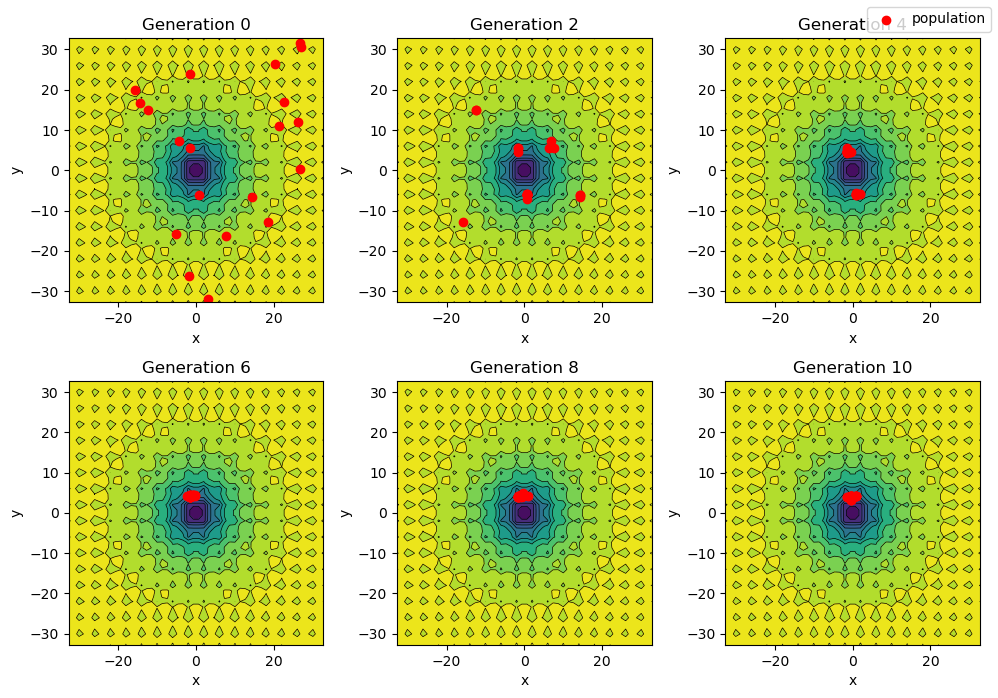

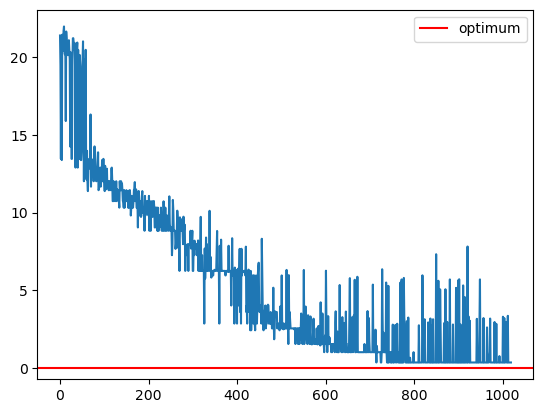

In [123]:
func = OptFun(bf.Ackley(2))

args["crossover_rate"] = 0.1
args["mutation_rate"] = 0.1
args["tournament_size"] = 2
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

best_guy, best_fitness, final_pop, all_populations = run_ga(
    Random(0), func, **args  # Seeded random number generator
)
print(best_guy, best_fitness)

plot_population_evolution(all_populations, func, generation_step=2)
func.plot()

In [ ]:
@dataclass(frozen=True)
class Result:
    mean_best_fitness: float
    std_best_fitness: float
    mean_best_individual: list[float]
    std_best_individual: list[float]

    def __repr__(self) -> str:
        return (
            f"Mean best fitness: {self.mean_best_fitness}\n"
            f"Std best fitness: {self.std_best_fitness}\n"
            f"Mean best individual: {self.mean_best_individual}\n"
            f"Std best individual: {self.std_best_individual}\n"
        )

    def __str__(self) -> str:
        return self.__repr__()


def run_ga_simulation(
    func: OptFun, num_simulations: int, args: Any, print_plots: bool
) -> Result:
    seeds = [pl.randint(0, 1000) for _ in range(num_simulations)]
    best_fitnesses: list[float] = []
    best_individuals = []
    best_fitness = None
    best_all_populations = []
    best_func = func

    for i in range(num_simulations):
        func = OptFun(bf.Ackley(2))
        b_guy, b_fitness, _, all_populations = run_ga(Random(seeds[i]), func, **args)
        best_fitnesses.append(b_fitness)
        best_individuals.append(b_guy)
        if best_fitness is None or b_fitness < best_fitness:
            best_fitness = b_fitness
            best_all_populations = all_populations
            best_func = deepcopy(func)

    mean_best_fitness: float = pl.mean(best_fitnesses).item()
    std_best_fitness: float = pl.std(best_fitnesses).item()
    mean_best_individual: list[float] = pl.mean(best_individuals, axis=0)
    std_best_individual: list[float] = pl.std(best_individuals, axis=0)

    if print_plots:
        plot_population_evolution(best_all_populations, best_func, generation_step=2)
        best_func.plot()
    return Result(
        mean_best_fitness, std_best_fitness, mean_best_individual, std_best_individual
    )

In [121]:
# Mutation only
from pprint import pprint

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0  # Standard deviation of the Gaussian mutations
args["num_elites"] = 1  # number of elite individuals to maintain in each gen
args["pop_size"] = 20  # population size
args["max_generations"] = 50  # Number of generations of the GA
args["crossover_rate"] = 0.0
args["mutation_rate"] = 0.1
args["tournament_size"] = 2
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

results: dict[str, Result] = {}
mutations = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for mutation in mutations:
    args["mutation_rate"] = mutation
    results[f"mutation_rate_{mutation}"] = run_ga_simulation(func, 10, args, False)
pprint(results)

<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Individual'>
<class 'inspyred.ec.ec.Indiv

In [ ]:
# Crossover only

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0  # Standard deviation of the Gaussian mutations
args["num_elites"] = 1  # number of elite individuals to maintain in each gen
args["pop_size"] = 20  # population size
args["max_generations"] = 50  # Number of generations of the GA
args["crossover_rate"] = 0.0
args["mutation_rate"] = 0.0
args["tournament_size"] = 2
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

results: dict[str, Result] = {}
crossovers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for crossover in crossovers:
    args["crossover_rate"] = crossover
    results[f"crossover_rate_{crossover}"] = run_ga_simulation(func, 10, args, False)
pprint(results)

In [ ]:
# Fix the mutation rate and change crossover rate
args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0  # Standard deviation of the Gaussian mutations
args["num_elites"] = 1  # number of elite individuals to maintain in each gen
args["pop_size"] = 20  # population size
args["max_generations"] = 50  # Number of generations of the GA
args["crossover_rate"] = 0.0
args["mutation_rate"] = 0.2
args["tournament_size"] = 2
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

results: dict[str, Result] = {}
crossovers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for crossover in crossovers:
    args["crossover_rate"] = crossover
    results[f"crossover_rate_{crossover}"] = run_ga_simulation(func, 10, args, False)
pprint(results)

In [ ]:
# Change tournament size
pop_size = 20
args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0  # Standard deviation of the Gaussian mutations
args["num_elites"] = 1  # number of elite individuals to maintain in each gen
args["pop_size"] = pop_size  # population size
args["max_generations"] = 50  # Number of generations of the GA
args["crossover_rate"] = 0.8
args["mutation_rate"] = 0.2
args["tournament_size"] = 2
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

results: dict[str, Result] = {}
tournament_size = range(2, pop_size, 2)
for size in tournament_size:
    args["tournament_size"] = size
    results[f"tournament_size_{size}"] = run_ga_simulation(func, 10, args, False)
pprint(results)

#### Exercise 2/3: Evolutionary Strategies

1. How does the number of offspring  λ  parameter affect the search?
2. How does the mixing number  ρ  affect the search?
3. Describe the impact of the different strategies (None/GLOBAL/INDIVIDUAL) on the search process.

In [ ]:
def run_es_simulation(
    func: OptFun, num_simulations: int, args: Any, print_plots: bool
) -> Result:
    seeds = [pl.randint(0, 1000) for _ in range(num_simulations)]
    best_fitnesses = []
    best_individuals = []
    best_fitness = None
    best_all_populations = []
    best_func = func

    for i in range(num_simulations):
        func = OptFun(bf.Ackley(2))
        b_guy, b_fitness, _, all_populations = run_es(Random(seeds[i]), func, **args)
        best_fitnesses.append(b_fitness)
        best_individuals.append(b_guy)
        if best_fitness is None or b_fitness < best_fitness:
            best_fitness = b_fitness
            best_all_populations = all_populations
            best_func = deepcopy(func)

    mean_best_fitness = pl.mean(best_fitnesses).item()
    std_best_fitness = pl.std(best_fitnesses).item()
    mean_best_individual = pl.mean(best_individuals, axis=0)
    std_best_individual = pl.std(best_individuals, axis=0)

    if print_plots:
        plot_population_evolution(best_all_populations, best_func, generation_step=2)
        best_func.plot()
    return Result(
        mean_best_fitness, std_best_fitness, mean_best_individual, std_best_individual
    )

In [ ]:
func = OptFun(bf.Ackley(2))

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["max_generations"] = 50
args["sigma"] = 1.0  # default standard deviation
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population
args["pop_size"] = 20  # mu
args["num_offspring"] = 100  # lambda
args["mixing_number"] = 5  # rho
args["strategy_mode"] = None

best_guy, best_fitness, final_pop, all_populations = run_es(
    Random(0), func, **args  # Seeded random number generator
)

plot_population_evolution(all_populations, func, generation_step=2)
func.plot()

In [109]:
# Change number of offspring
func = OptFun(bf.Ackley(2))
num_simulations = 10
pop_size = 20

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["max_generations"] = 50
args["sigma"] = 1.0  # default standard deviation
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population
args["pop_size"] = 20  # mu
args["num_offspring"] = 100  # lambda
args["mixing_number"] = 5  # rho
args["strategy_mode"] = None


results: dict[str, Result] = {}
num_offsprings = range(pop_size, pop_size * 10, pop_size)
for mix_number in num_offsprings:
    args["num_offspring"] = mix_number
    results[f"num_offspring_{mix_number}"] = run_es_simulation(
        func, num_simulations, args, False
    )
pprint(results, sort_dicts=False)

{'num_offspring_20': Mean best fitness: 0.21992122465017028
Std best fitness: 0.18615150829025365
Mean best individual: [0.003272   0.00664419]
Std best individual: [0.04493506 0.03584546]
,
 'num_offspring_40': Mean best fitness: 0.07978258367908966
Std best fitness: 0.053364806404975644
Mean best individual: [0.01039684 0.00413433]
Std best individual: [0.01304223 0.01881352]
,
 'num_offspring_60': Mean best fitness: 0.07398868941670331
Std best fitness: 0.04534419244327495
Mean best individual: [ 0.00036868 -0.01023188]
Std best individual: [0.01563776 0.01477913]
,
 'num_offspring_80': Mean best fitness: 0.06423963420451076
Std best fitness: 0.04005970707946115
Mean best individual: [0.00587383 0.00153557]
Std best individual: [0.01740233 0.0104868 ]
,
 'num_offspring_100': Mean best fitness: 0.05812590418971242
Std best fitness: 0.02426559259494991
Mean best individual: [-0.00070729 -0.00650167]
Std best individual: [0.01388716 0.01032769]
,
 'num_offspring_120': Mean best fitness

In [110]:
# Change mixing number
func = OptFun(bf.Ackley(2))
num_simulations = 10
pop_size = 20

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["max_generations"] = 50
args["sigma"] = 1.0  # default standard deviation
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population
args["pop_size"] = 20  # mu
args["num_offspring"] = 100  # lambda
args["mixing_number"] = 5  # rho
args["strategy_mode"] = None


results: dict[str, Result] = {}
mixing_numbers = range(2, pop_size)
for mix_number in mixing_numbers:
    args["mixing_number"] = mix_number
    results[f"mixing_number_{mix_number}"] = run_es_simulation(
        func, num_simulations, args, False
    )
pprint(results, sort_dicts=False)

{'mixing_number_2': Mean best fitness: 0.050050912298710504
Std best fitness: 0.04013512424232593
Mean best individual: [ 0.00426272 -0.00224682]
Std best individual: [0.01587532 0.00692273]
,
 'mixing_number_3': Mean best fitness: 0.05759459520320016
Std best fitness: 0.021332224396396194
Mean best individual: [-0.00504506  0.00521844]
Std best individual: [0.00937213 0.01374978]
,
 'mixing_number_4': Mean best fitness: 0.09278899831504903
Std best fitness: 0.061833712005238115
Mean best individual: [-0.00577225  0.00536996]
Std best individual: [0.01886039 0.02060644]
,
 'mixing_number_5': Mean best fitness: 0.07462282994424223
Std best fitness: 0.037464132110051354
Mean best individual: [ 0.00225859 -0.00129167]
Std best individual: [0.01860223 0.01370936]
,
 'mixing_number_6': Mean best fitness: 0.062366704363876216
Std best fitness: 0.047119182101215004
Mean best individual: [-0.0016027  -0.00479414]
Std best individual: [0.01156565 0.01732023]
,
 'mixing_number_7': Mean best fitn

In [111]:
# Change strategy mode
func = OptFun(bf.Ackley(2))
num_simulations = 10
pop_size = 20

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["max_generations"] = 50
args["sigma"] = 1.0  # default standard deviation
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population
args["pop_size"] = 20  # mu
args["num_offspring"] = 100  # lambda
args["mixing_number"] = 5  # rho
args["strategy_mode"] = None


results: dict[str, Result] = {}
strategies = [None, GLOBAL, INDIVIDUAL, CORRELATED]
for strategy in strategies:
    args["strategy_mode"] = strategy
    results[f"strategy_{strategy}"] = run_es_simulation(
        func, num_simulations, args, False
    )
pprint(results, sort_dicts=False)

Exception: NumpyRandomWrapper required for correlated mutations

#### Exercise 3/3: Particle Swarm Optimization

1. How does PSO compare to GA on different benchmark functions?
2. How does PSO compare to ES on different benchmark functions?
3. Vary the pop_size and the n. of generations in such a way that their product is always constant, and compare the outcome of the search (over multiple runs). What is better? To have higher pop_size or higher number of generations?

In [ ]:
func = OptFun(bf.Ackley(2))

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

args["pop_size"] = 50  # mu
args["topology"] = STAR  # RING, STAR
args["neighborhood_size"] = 2  # used only for the ring topology
args["inertia"] = 0.3
args["cognitive_rate"] = 0.5
args["social_rate"] = 2.1
args["max_generations"] = 50

best_guy, best_fitness, final_pop, all_populations = run_pso(
    Random(0), func, **args  # Seeded random number generator
)

plot_population_evolution(all_populations, func, generation_step=2)
func.plot()

In [113]:
def run_pso_simulation(
    func: OptFun, num_simulations: int, args: Any, print_plots: bool
) -> Result:
    seeds = [pl.randint(0, 1000) for _ in range(num_simulations)]
    best_fitnesses = []
    best_individuals = []
    best_fitness = None
    best_all_populations = []
    best_func = func

    for i in range(num_simulations):
        func = OptFun(bf.Ackley(2))
        b_guy, b_fitness, _, all_populations = run_pso(Random(seeds[i]), func, **args)
        best_fitnesses.append(b_fitness)
        best_individuals.append(b_guy)
        if best_fitness is None or b_fitness < best_fitness:
            best_fitness = b_fitness
            best_all_populations = all_populations
            best_func = deepcopy(func)

    mean_best_fitness = pl.mean(best_fitnesses).item()
    std_best_fitness = pl.std(best_fitnesses).item()
    mean_best_individual = pl.mean(best_individuals, axis=0)
    std_best_individual = pl.std(best_individuals, axis=0)

    if print_plots:
        plot_population_evolution(best_all_populations, best_func, generation_step=2)
        best_func.plot()
    return Result(
        mean_best_fitness, std_best_fitness, mean_best_individual, std_best_individual
    )

In [115]:
# constant pop_size * num_generations
func = OptFun(bf.Ackley(2))

args = {}
args["num_vars"] = 2  # Number of dimensions of the search space
args["pop_init_range"] = func.bounds()[0]  # Range for the initial population

args["pop_size"] = 50  # mu
args["topology"] = STAR  # RING, STAR
args["neighborhood_size"] = 2  # used only for the ring topology
args["inertia"] = 0.3
args["cognitive_rate"] = 0.5
args["social_rate"] = 2.1
args["max_generations"] = 50

results: dict[str, Result] = {}
product = 50 * 50
pop_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for size in pop_sizes:
    args["pop_size"] = size
    generations = product // size
    args["max_generations"] = generations
    results[f"size_{size}_generations_{generations}"] = run_pso_simulation(
        func, num_simulations, args, False
    )
pprint(results, sort_dicts=False)

{'size_10_generations_250': Mean best fitness: 0.2579927557029884
Std best fitness: 0.7739782671089616
Mean best individual: [-9.52166553e-02  6.10415047e-10]
Std best individual: [2.85649966e-01 1.83124598e-09]
,
 'size_20_generations_125': Mean best fitness: 4.440892098500626e-16
Std best fitness: 0.0
Mean best individual: [-6.54261406e-17 -4.57500899e-17]
Std best individual: [2.26381208e-16 1.28873680e-16]
,
 'size_30_generations_83': Mean best fitness: 4.352074256530614e-15
Std best fitness: 4.035107072155791e-15
Mean best individual: [ 5.83339868e-16 -8.01272198e-16]
Std best individual: [1.54872134e-15 9.16463574e-16]
,
 'size_40_generations_62': Mean best fitness: 1.4829826255891022e-11
Std best fitness: 1.0497759439733202e-11
Mean best individual: [-1.52244113e-12 -1.35010464e-12]
Std best individual: [1.36816319e-12 5.93735112e-12]
,
 'size_50_generations_50': Mean best fitness: 2.698165690873111e-09
Std best fitness: 2.3400472317312554e-09
Mean best individual: [-1.63110515e